#### **Import Libraries**

In [263]:
import jax 
import jax.numpy as jnp
from jax import Array
from functools import partial 
from einops import rearrange
import optax 
from tqdm import tqdm 
from rfp import MLP, Model, ModelParams
from rfp.losses import Supervised_Loss, mse
from rfp.train import Trainer


#### **Set Up Plotting**

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/home/ubuntu/rfp/styles/Newsreader/static/Newsreader_9pt/Newsreader_9pt-Italic.ttf


#### **Data Hyperparameters**

In [277]:
n = 20             # Observations per cluster
d = 4              
c = 25            # Number of clusters
init_key = jax.random.PRNGKey(0)
nodes = 128 
lr = 1e-3
epochs = 100 

#### **Main Function**

In [292]:
def original_function(x: Array) -> Array:
    """
    Non-linear function of four variables.
    x: jnp.ndarray of shape (n, 4), where n is the number of samples.
    """
    return jnp.exp(-0.5 * jnp.sum(x ** 2, axis=-1))

def integrated_function(x: Array) -> Array:
    """
    Function of the first three variables after integrating out the fourth variable.
    x: jnp.ndarray of shape (n, 3), where n is the number of samples.
    """
    return jnp.exp(-0.5 * jnp.sum(x ** 2, axis=-1)) * jnp.sqrt(2 * jnp.pi)

#### **Sample Data**

In [304]:
def obs_sample(n: int, d: int, key: jax.random.PRNGKey) -> tuple[Array, Array]:
    k1, k2 = jax.random.split(key, 2)
    mean = jax.random.normal(k1, shape=(d,))
    xs = jax.random.multivariate_normal(k1, mean=mean, cov=jnp.eye(d), shape=(n,))
    ys = jax.vmap(original_function)(xs).reshape(-1, 1) + 0.1 * jax.random.normal(k2, shape=(n, 1))
    return xs, ys

@partial(jax.jit, static_argnums=(0,1))
def cluster_batch_sample(n, c, key):
    xs, ys = jax.vmap(partial(obs_sample, n, 4))(jax.random.split(init_key, c))
    xs =  rearrange(xs, 'a b c -> (a b) c')
    ys = rearrange(ys, 'a b c -> (a b) c')
    return xs, ys, jax.vmap(original_function)(xs).reshape(-1,)

@partial(jax.jit, static_argnums=(0,1))
def iid_batch_sample(n, c, key):
    xs, ys = jax.vmap(partial(obs_sample, 1, 4))(jax.random.split(init_key, n*c))
    xs =  rearrange(xs, 'a b c -> (a b) c')[:, :-1]
    ys = rearrange(ys, 'a b c -> (a b) c')
    return xs, ys, jax.vmap(integrated_function)(xs).reshape(-1,1)


#### **Model Setup**

In [305]:
features = 3 ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes, nodes], jax.nn.relu)
final_activation_fn = lambda x: x; print(f"Final Activation Function: {final_activation_fn}")
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(mse, model.fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)

def simulate_iid( n: int, c: int, key: jax.random.PRNGKey):
    k1, k2, k3 = jax.random.split(key, 3)

    xs, ys, target = iid_batch_sample( n, c, k1)
    m,std = jnp.mean(ys), jnp.std(ys)
    ys = (ys - m)/std
    xs = jax.nn.standardize(xs, axis=0)
    params = ModelParams.init_fn(k2, mlp, features)

    # Split Train and Validation Data
    idx = jax.random.permutation(k3, n*c)
    train_idx = idx[:(n*c)//2]
    val_idx = idx[(n*c)//2:]
    is_in_train = jnp.isin(jnp.arange(n*c), train_idx)
    is_in_val = jnp.isin(jnp.arange(n*c), val_idx)

    params, opt_params, training_loss, validation_loss = yuri.train_with_val(params, xs, ys, jnp.ones_like(ys), is_in_train, is_in_val)
    yhat = (model.fwd_pass(opt_params, xs) + m)*std
    return opt_params, training_loss, validation_loss, yhat, target

Number of Features: 3
Final Activation Function: <function <lambda> at 0x7f7600d008b0>


In [288]:
val_iid_loss = []
key = jax.random.PRNGKey(0)
for _ in tqdm(range(10)):
    _, validation_loss = simulate_iid(n, c, key)
    val_iid_loss.append(jnp.min(validation_loss))
    key, _ = jax.random.split(key)

100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


In [302]:
opt_params, _, validation_loss, yhat, target = simulate_iid(n, c, key)


In [303]:
target.shape

(500,)

In [289]:
features = 4 ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes, nodes], jax.nn.relu)
final_activation_fn = lambda x: x; print(f"Final Activation Function: {final_activation_fn}")
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(mse, model.fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)

def simulate_cluster( n: int, c: int, key: jax.random.PRNGKey):
    k1, k2, k3 = jax.random.split(key, 3)

    xs_cluster, ys_cluster = cluster_batch_sample( n, c, k1)
    ys_cluster = (ys_cluster - jnp.mean(ys_cluster))/jnp.std(ys_cluster)
    xs_cluster = jax.nn.standardize(xs_cluster, axis=0)
    params = ModelParams.init_fn(k2, mlp, features)

    # Split Train and Validation Data
    idx = jax.random.permutation(k3, n*c)
    train_idx = idx[:(n*c)//2]
    val_idx = idx[(n*c)//2:]
    is_in_train = jnp.isin(jnp.arange(n*c), train_idx)
    is_in_val = jnp.isin(jnp.arange(n*c), val_idx)

    params, opt_params, training_loss, validation_loss = yuri.train_with_val(params, xs_cluster, ys_cluster, jnp.ones_like(ys_cluster), is_in_train, is_in_val)
    return training_loss, validation_loss

Number of Features: 4
Final Activation Function: <function <lambda> at 0x7f75d9a80820>


In [290]:
val_cluster_loss = []
key = jax.random.PRNGKey(0)
for _ in tqdm(range(10)):
    _, validation_loss = simulate_cluster(n, c, key)
    val_cluster_loss.append(jnp.min(validation_loss))
    key, _ = jax.random.split(key)

100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


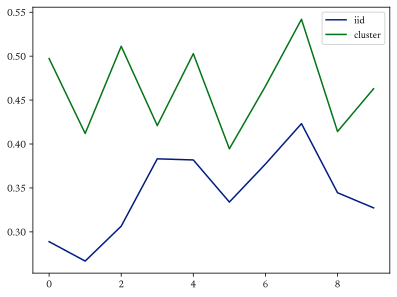

In [291]:
plt.plot(val_iid_loss, label='iid')
plt.plot(val_cluster_loss, label='cluster')
plt.legend()
plt.show()

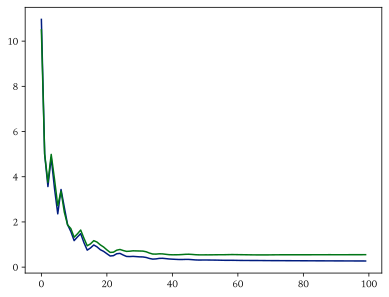

In [257]:
plt.plot(training_loss)
plt.plot(validation_loss)
plt.show()

In [59]:
xs_iid, ys_iis = iid_batch_sample(obs_per_cluster*n_clusters, init_key)

In [60]:
xs_iid.shape

(60, 3)